In [1]:
cd /Users/jz-rolling/PycharmProjects/CleanSpace/momia2

/Users/jz-rolling/PycharmProjects/CleanSpace/momia2


In [131]:
import momia2 as mo
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure,filters,feature
from microfilm.microplot import microshow
from matplotlib.patches import Rectangle
from scipy import ndimage as ndi

In [3]:
loader = mo.ImageLoader('/Volumes/Extreme_SSD/20230527_FFPE_pilot2/test_009.nd2')

In [21]:
# perform rolling ball substraction then z_max

data_dict = {}
for i in range(loader.n_zpositions):
    slice_data = loader.get_slice_all_channels(zplane=i)
    #for c in ['CFP','TRITC','DAPI']:
        #slice_data[c+'bg_subtracted'] = mo.utils.corrections.rolling_ball_bg_subtraction(slice_data[c])
    data_dict[i] = slice_data

In [25]:
drift_corrected = {}

In [30]:
drift = [[np.array([0.,0.]),np.array([0.,0.])]]
for i in range(1,loader.n_zpositions):
    c1 = data_dict[i-1]['CFP']
    c2 = data_dict[i]['CFP']
    c3 = data_dict[i]['TRITC']
    drift_z = mo.utils.drift_detection(img=c2,reference=c1,upsample_factor=100)
    drift_c = mo.utils.drift_detection(img=c3,reference=c2,upsample_factor=100)
    last_drift = drift[-1].copy()
    drift.append([last_drift[0]+drift_z,last_drift[1]+drift_c])

In [54]:
drift_corrected[0] = data_dict[0]
drift_corrected[0]['TRITC_sub_CFP'] = drift_corrected[0]['TRITC']/(drift_corrected[0]['CFP']-200)
for i in range(1,loader.n_zpositions):
    d1 = drift[i][0]
    d2 = drift[i][0]+drift[i][1]
    drift_corrected[i]={'DAPI':data_dict[i]['DAPI'],'Phase_Ian':data_dict[i]['Phase_Ian']}
    drift_corrected[i]['CFP'] = mo.utils.drift_correction(data_dict[i]['CFP'],d1)
    drift_corrected[i]['TRITC'] = mo.utils.drift_correction(data_dict[i]['TRITC'],d2) 
    drift_corrected[i]['TRITC_sub_CFP'] = drift_corrected[i]['TRITC']/(drift_corrected[i]['CFP']-200)

In [279]:
bg_subtracted = {}
for i in range(loader.n_zpositions):
    a = drift_corrected[i]['TRITC']
    b = drift_corrected[i]['CFP']
    ratio = (mo.utils.normalize_image(exposure.adjust_sigmoid(a/b),mask=False)*65535).astype(np.uint16)
    bg_subtracted[i] = {'TRITC':mo.utils.rolling_ball_bg_subtraction(ratio),
                        'DAPI':mo.utils.rolling_ball_bg_subtraction(drift_corrected[i]['DAPI']),
                        'CFP':(mo.utils.normalize_image(b,mask=None,max_perc=99.5,min_perc=0.05)*65535).astype(np.uint16)}

In [328]:
z_max_TRITC = filters.median(np.array([exposure.adjust_sigmoid(v['TRITC'],cutoff=0.25,gain=12) for k,v in bg_subtracted.items()]).max(axis=0))
z_max_TRITC = mo.utils.subtract_background(z_max_TRITC)
z_max_CFP = mo.utils.subtract_background(np.array([exposure.adjust_sigmoid(v['CFP'],cutoff=0.25,gain=12) for k,v in bg_subtracted.items()])[-9:].max(axis=0))
z_max_DAPI = np.array([v['DAPI'] for k,v in bg_subtracted.items()]).max(axis=0)
phase = data_dict[5]['Phase_Ian']
images = [ndi.median_filter(z_max_TRITC,5),z_max_DAPI,filters.gaussian(z_max_CFP,3,preserve_range=True)]

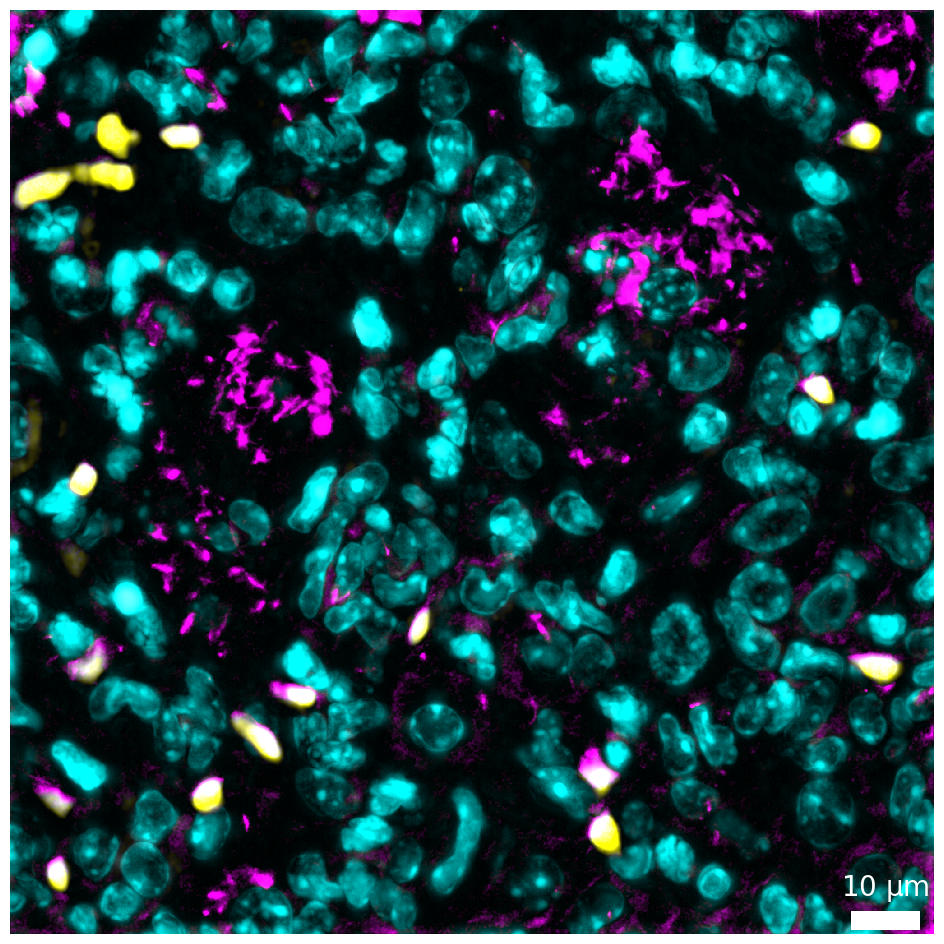

In [333]:
fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot()
microim = microshow(
    images=images,#[x[730:1330,830:1430] for x in images], 
    ax=ax,
    limits = [[5000,30000],[100,10000],[500,3000]],
    cmaps=['pure_magenta','pure_cyan','pure_yellow'],
    unit='µm', 
    scalebar_size_in_units=10, 
    scalebar_unit_per_pix=loader.pixel_microns, 
    scalebar_font_size=20,
    label_text='A', 
    label_font_size=0.02)
#ax.add_patch(Rectangle([830,730],width=600,height=600,ec='w',lw=3,fill=False))
plt.savefig('/Users/jz-rolling/Desktop/labnotes_transferred/FISH/manuscript/data_clips/20230527_Erdman_FeJ_16srRNA_100X_006.tif',dpi=160,bbox_inches='tight')

In [332]:
loader.pixel_microns

0.065

In [153]:
z_max_TRITC.min()

17625

In [76]:
microfilm.colorify()

TypeError: 'module' object is not callable